Get Externals, Note use of commentjson

In [1]:
import os,sys,string,time,commentjson
from csv import reader
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np

Utility function: object = cummulate(object,lifetime)

In [2]:
# sum backwards over lifetime of record
def cumulate(a,lifetime=100):
  if lifetime < 1:
    return a*lifetime
  b = np.zeros(len(a))
  for i in range(0,len(a)):
    begin = max(0,i-lifetime+1)
    for j in range(begin,i+1):
      b[i] += a[j]
  return b
  

Utility function: string = dump(datatype,det,object,Units)

In [3]:
from NumberUtils import dump


Utility function: DrawDet(Value,Years,Data,Types,Units,detcolors,detlines)

In [4]:
from NumberUtils import DrawDet  


Utility function: DrawType(Value,Years,Data,Types,Units,typecolors,typelines)

In [5]:
# draw by data type (transpose of the detectors)
from NumberUtils import DrawType

Main initialization

Read in the config file "Parameters2040.json"

In [6]:
# get parameters into config

configfile = "Parameters_2040.json"
if os.path.exists(configfile):
  with open(configfile,'r') as f:
    config = commentjson.load(f)
else:
  print ("no config file",configfile)
  sys.exit(0)

Print the json file 

In [7]:
json_formatted_str = commentjson.dumps(config, indent=2)

#print(json_formatted_str)

    Set up parameters from input file 

In [8]:
# set up shortcuts for parameters

Years = np.array(config["Years"])
size = len(Years)

Units = config["Units"]

Detectors = config["Detectors"]

CombinedDetectors = config["CombinedDetectors"]

DetectorParameters = list(config["SP"].keys())

TapeLifetimes = config["TapeLifetimes"]

DiskLifetimes = config["DiskLifetimes"]

TapeCopies = config["TapeCopies"]

DiskCopies = config["DiskCopies"]

RecoMemory = config["RecoMemory"]



PerYear = config["PerYear"]

StorageTypes = list(TapeCopies.keys())

# plot config
DetColors=config["DetColors"]
DetLines = config["DetLines"]
TypeColors=config["TypeColors"]
TypeLines = config["TypeLines"]

Make data structures - Inputs and Data 

Data[type][det] is an dictionary keyed on type and detector

In [9]:
# build the inputs array

Inputs = {}
PatternFraction = config["PatternFraction"]
# get in the input values (Events and amount of commissioning in TB)
 
# these variables are set in the json file

dofirst = ["Events","Test","Sim Events"]

for det in ["SP","DP","ND","FD"]:
  Inputs[det]={}

  for type in dofirst:
    Inputs[det][type] = np.array(config[det][type])
    print ("size", det,type, Inputs[det][type].size)
    

size SP Events 23
size SP Test 23
size SP Sim Events 23
size DP Events 23
size DP Test 23
size DP Sim Events 23
size ND Events 23
size ND Test 23
size ND Sim Events 23
size FD Events 23
size FD Test 23
size FD Sim Events 23


In [10]:
# use those to calculate CPU and space needs
    
for det in Detectors:
    
  for key in DetectorParameters:
    # skip the ones already done
    if key in dofirst:
      continue
    # sim has its own configuration 
    if not "Sim" in key:
      
      if key in ["CPU","Reco"]:  # if doing reco, do over previous events using memory
            Inputs[det][key] = cumulate(Inputs[det]["Events"],RecoMemory[det])*config[det][key]
             
      else:
            Inputs[det][key]=Inputs[det]["Events"]*config[det][key]
    else:
      Inputs[det][key]=Inputs[det]["Sim Events"]*config[det][key]
      
# write some of this out
#print (Inputs["ND"])
o = open("out.csv",'w')
o.write(dump("Year","Years",Years,Units))


251

In [11]:
# use inputs to calculate per year sizes and store in transposed map Data

Data = {}
print (Inputs.keys())
for dtype in Inputs["ND"].keys():
  Data[dtype] = {} 
  #Data["Full-Reco"] = {}
  for det in Inputs.keys():
    # this allows you to, say, do 2 passes of reco/year
    Data[dtype][det] = Inputs[det][dtype] * float(PerYear[dtype])
    # compensate for nominal units being millions and TB or singles and MB
    if Units[dtype] == "PB":
      Data[dtype][det] *= 0.001
    o.write(dump(det,dtype,Data[dtype][det],Units))
    
# replace Reco with reconstruction over previous years



dict_keys(['SP', 'DP', 'ND', 'FD'])


For FD and ND assume reprocess full sample when get new reco version 

In [12]:
# Detectors = Data["CPU"].keys()
# Data["Full-CPU"] = {}
# # it's a sum of doing hit finding once but then doing pattern recognition over again each time 
# for det in Detectors:
#     Data["Full-CPU"][det] = cumulate(Data["CPU"][det],RecoMemory[det])*PatternFraction[det] + cumulate(Data["CPU"][det],1)*(1-PatternFraction[det])


In [13]:
print ("types",Data.keys())
print ("detectors", Data["Events"].keys())
print ("values", Data["Events"]["FD"])

types dict_keys(['Events', 'Test', 'Sim Events', 'Raw', 'CPU', 'Sim-CPU', 'Reco', 'Sim'])
detectors dict_keys(['SP', 'DP', 'ND', 'FD'])
values [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.2 2.2 4.4 4.4 4.4 6.6 6.6 6.6
 8.8 8.8 8.8 8.8 8.8]


Now draw the # of events/year

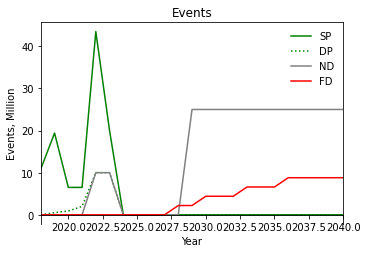

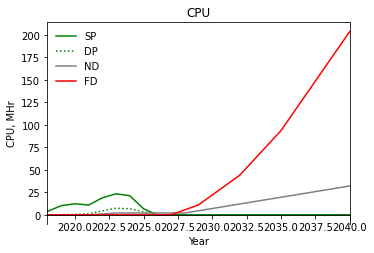

In [14]:
DrawDet("Events",Years,Data,Inputs.keys(),Units,DetColors,DetLines)
#DrawDet("CPU",Years,Data,Inputs.keys(),Units,DetColors,DetLines)
DrawDet("CPU",Years,Data,Inputs.keys(),Units,DetColors,DetLines)

Combine the protoDUNEs into one and replace them in Data

In [15]:
# combine ProtoDUNEs into one and get rid of SP and DP

for dtype in Data.keys():
  det = "ProtoDUNE"
  print (dtype)
  Data[dtype][det] = Data[dtype]["SP"] + Data[dtype]["DP"]
  Data[dtype].pop("SP")
  Data[dtype].pop("DP")
  o.write(dump(det,dtype,Data[dtype][det],Units))

Events
Test
Sim Events
Raw
CPU
Sim-CPU
Reco
Sim


Make a Total-CPU datatype, and a Total "detector" which sums over detectors

In [16]:
# make a total CPU category

Data["Total-CPU"]={}

for det in CombinedDetectors:
  Data["Total-CPU"][det] =  Data["CPU"][det] + Data["Sim-CPU"][det]
  
Data.pop("CPU")
# sum up data across detectors.

DataTypes = list(Data.keys())
print (DataTypes)
for dt in DataTypes:
  Data[dt]["Total"] = np.zeros(size)
  for k in Data[dt].keys():
    if k == "Total":
      continue
    Data[dt]["Total"] += Data[dt][k]

['Events', 'Test', 'Sim Events', 'Raw', 'Sim-CPU', 'Reco', 'Sim', 'Total-CPU']


Make an Analysis "detector" that scales with sum of CPU use for all detectors them and add into Total-CPU

In [17]:
# assume analysis CPU = some multiplier of total sim + reco

Data["Total-CPU"]["Analysis"]= np.zeros(size)
for det in config["Analysis"]["Add"]:
    # scale allows you to change the scale of analysis relative to reconstruction and simulations
  Data["Total-CPU"]["Analysis"]+= Data["Total-CPU"][det]*config["Analysis"]["Scale"]
  
o.write(dump("Analysis","Total-CPU",Data["Total-CPU"]["Analysis"],Units))
  
# and put it in the total

Data["Total-CPU"]["Total"] += Data["Total-CPU"]["Analysis"]

Make a Cores type that is just CPU scaled to a 2020 CPU with some efficiency

In [18]:
# and make a special data type for cores

Data["Cores"] = {}
MHrsPerYear = 1000000./365/24
for k in Data["Total-CPU"].keys():
  efficiency = config["Cores"]["Efficiency"]
  scaleTo2020 = config["Cores"]["2020Units"]
  Data["Cores"][k] = Data["Total-CPU"][k]*MHrsPerYear/efficiency/scaleTo2020

In [19]:

# write out the totals

for k in Data.keys():
  #print ("total:",k,Units[k], Data[k]["Total"])
  o.write(dump("Total",k,Data[k]["Total"],Units))


Use the data lifetimes and # of copies to sum up cumulative amounts for disk and tape 

In [20]:

# now do some cumulative work.  Stuff stays on tape/disk for different amounts of time and we have multiple copies

Data["Total"] = {}
Data["Total"]["Cumulative Tape"] = 0
Data["Total"]["Cumulative Disk"] = 0
for k in StorageTypes:
  Data[k]["Tape"] = Data[k]["Total"]*TapeCopies[k]
  o.write(dump("Tape Copies",k,Data[k]["Tape"],Units))
  Data[k]["Disk"] = Data[k]["Total"]*DiskCopies[k]
  o.write(dump("Disk Copies",k,Data[k]["Disk"],Units))
  Data[k]["Cumulative Tape"] = cumulate(Data[k]["Tape"],TapeLifetimes[k])
  o.write(dump("Cumulative Tape",k,Data[k]["Cumulative Tape"],Units))
  Data[k]["Cumulative Disk"] = cumulate(Data[k]["Disk"],DiskLifetimes[k])
  o.write(dump("Cumulative Disk",k,Data[k]["Cumulative Disk"],Units ))
  Data["Total"]["Cumulative Tape"] += Data[k]["Cumulative Tape"]
  Data["Total"]["Cumulative Disk"] += Data[k]["Cumulative Disk"]
o.write(dump("Cumulative Tape","All",Data["Total"]["Cumulative Tape"],Units ))
o.write(dump("Cumulative Disk","All",Data["Total"]["Cumulative Disk"],Units ))

263

Draw various summaries

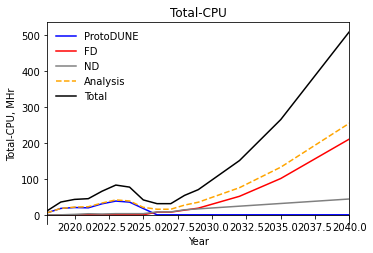

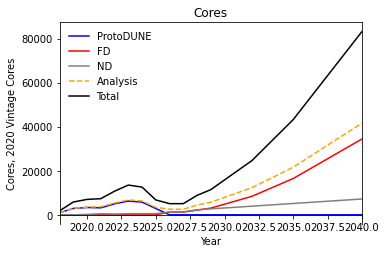

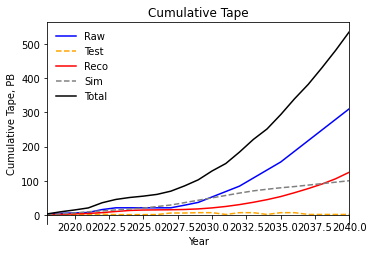

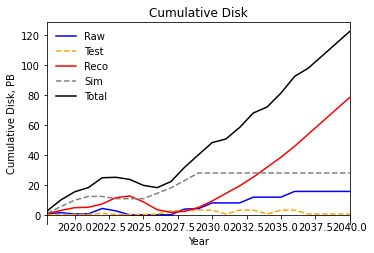

In [21]:
Types = ["ProtoDUNE","FD","ND","Analysis","Total"]

DrawDet("Total-CPU",Years,Data,Types,Units,DetColors,DetLines)
DrawDet("Cores",Years,Data,Types,Units,DetColors,DetLines)
DrawType("Cumulative Tape",Years,Data,StorageTypes+["Total"],Units,TypeColors,TypeLines)
DrawType("Cumulative Disk",Years,Data,StorageTypes+["Total"],Units,TypeColors,TypeLines)
